In [1]:
%matplotlib inline
import numpy as np
import numpy.random as rng
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
maryland_customers = pd.read_csv("data/allstate/cgr-premiums-table.csv")
territory = pd.read_csv("data/allstate/territory-definitions-table.csv")
cgr = pd.read_csv("data/allstate/cgr-definitions-table.csv")
acs03 = pd.read_csv("data/allstate/ACS_MD_15_5YR_DP03.csv")
acs05 = pd.read_csv("data/allstate/ACS_MD_15_5YR_DP05.csv")

## Data Cleaning 

In [4]:
acs05['population'] = acs05['HC01_VC94'] + acs05['HC01_VC88'] + acs05['HC01_VC95'] + acs05['HC01_VC96'] + acs05['HC01_VC97'] + acs05['HC01_VC98'] + acs05['HC01_VC99']
acs05['percentage_nonwhite'] = 1.0 * (acs05['population'] - acs05['HC01_VC94']) / acs05['population']
acs05['majority_minority'] = acs05['percentage_nonwhite'] > 0.5
race = acs05[['GEO.id2', 'population', 'percentage_nonwhite', 'majority_minority']]
acs03['median_income'] = acs03['HC01_VC85']
income = acs03[['GEO.id2', "median_income"]]
initial_row_count =  maryland_customers.shape[0]

In [5]:
## merge maryland, territory and cgr tables together
cgr_new = cgr[['cgr', 'aa']]
maryland_customers = pd.merge(maryland_customers, cgr_new, how = "left", on ='cgr')
maryland_customers['cgr_factor'] = maryland_customers['aa']
maryland_customers['aa'] = None 

In [6]:
## Drop duplicate zip codes in the territory table
territory = territory.drop_duplicates(subset = ['territory'])
## Merge Allstate's "territory definitions" (geographic data) with each row so we can use Census data
maryland_customers =  pd.merge(maryland_customers, territory, how = 'left', on ="territory")

In [7]:
## Merge the ACS data for each Maryland policy holder
maryland_customers = pd.merge(maryland_customers, race, how = 'left' , left_on = "zipcode", right_on ="GEO.id2")
maryland_customers = pd.merge(maryland_customers, income, how = 'left', left_on = "zipcode", right_on="GEO.id2")

# Feature Engineering

In [8]:
## Renaming the variables 
maryland_customers.rename(columns = {'current_premium' : 'current_price',
                                     'selected_premium': 'transition_price', 
                                     'indicated_premium':'ideal_price'}, inplace = True)


In [9]:
## Calculating the percentage change of indicated and selected premiums.
maryland_customers['price_change'] = (maryland_customers['transition_price'] - maryland_customers['current_price']) / maryland_customers['current_price'] * 100
maryland_customers['ideal_price_change'] = (maryland_customers['ideal_price'] - maryland_customers['current_price']) / maryland_customers['current_price'] * 100

In [10]:
effective_date = pd.Timestamp("04/11/2014")
maryland_customers['dob'] = pd.to_datetime(maryland_customers['birthdate'])
maryland_customers['dob'] = maryland_customers['dob'].where(maryland_customers['dob'] < effective_date, maryland_customers['dob'] -  np.timedelta64(100, 'Y'))   
maryland_customers['age'] = (effective_date - maryland_customers['dob']).astype('<m8[Y]') 
#maryland$age <- floor(time_length(difftime(effective_date, as.Date(maryland$birthdate, "%m/%d/%Y")),"years"))

In [11]:
##categorize into three buckets of age as observed in dataset
bins = [0, 41, 62, 100]
labels = ['16-40','41-62','63+']
maryland_customers['age_bucket'] = pd.cut(maryland_customers['age'], bins=bins, labels=labels)

In [12]:
## Break into rough categories of percentage shifts as observed in the "Effects of the Retention Model on Maryland Customers" section of the white paper
maryland_customers['shift_category'] = np.where(maryland_customers['price_change']>=9.5, 'Large Increase', 'Small Discount')
maryland_customers['shift_category'] = np.where((maryland_customers['current_price'] < maryland_customers['transition_price']) & (maryland_customers['shift_category'] == "Small Discount"),"Small Increase", maryland_customers['shift_category'])

In [13]:
## Take binomial signals identified in the paper and turn them ino booleans
maryland_customers['is_above_current'] = maryland_customers['current_price'] >= 1883
maryland_customers['is_above_difference'] = maryland_customers['ideal_price'] - maryland_customers['current_price'] >= 381
maryland_customers['is_both'] = maryland_customers['is_above_current'] & maryland_customers['is_above_difference']
maryland_customers['IndMinCur'] = maryland_customers['ideal_price']- maryland_customers['current_price']
maryland_customers['SelMinCur'] = maryland_customers['transition_price'] - maryland_customers['current_price']
maryland_customers['SelDivCur'] = maryland_customers['transition_price'] / maryland_customers['current_price']
maryland_customers['IncDivCur'] = maryland_customers['ideal_price'] / maryland_customers['current_price']
maryland_customers['SelDivInd'] = maryland_customers['transition_price'] / maryland_customers['ideal_price']

In [14]:
##categorize into three buckets
maryland_customers['IncCat'] = np.where(maryland_customers['SelDivCur'] <= 1, "Decreased or No Change", maryland_customers['SelDivCur'])
maryland_customers['IncCat'] = np.where((maryland_customers['SelDivCur'] > 1) & (maryland_customers['SelDivCur'] < 1.0502) , "Small Increase", "Large Increase")


In [15]:
##cut percentange_nonwhite into four equal intervals
bins = [0,0.25,0.5,0.75,1]
labels = ["0-0.25",">0.25-.5",">0.5-0.75",">0.75-1"]
maryland_customers['PNW_bucket4'] = pd.cut(maryland_customers['percentage_nonwhite'], bins = bins, labels = labels)

In [16]:
#drop policy holders with no demographic information
md = maryland_customers.dropna(subset = ['median_income', 'percentage_nonwhite'])

In [17]:
md['percent_non_white'] = md['PNW_bucket4']

In [18]:
md.to_csv('data/maryland_premimum_final.csv')

In [148]:
md.shape[0]

92722

In [133]:
md1 = md.loc[md['ideal_price'] <= 6000, ]

UsageError: Cell magic `%%R` not found.


In [119]:
sum(md['current_price'] > md['ideal_price']) / md.shape[0]

0.5283212182653524

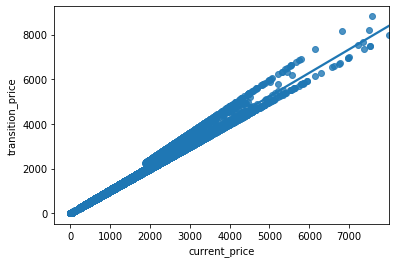

In [127]:
sns.scatterplot(data=md, x="current_price", y="transition_price")

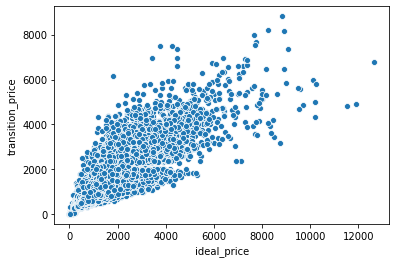

In [184]:
aggregate_plot = sns.scatterplot(data=md, x="ideal_price", y="transition_price")
aggregate_plot = aggregate_plot.get_figure()
aggregate_plot.savefig("eda_plots/aggregate.png")

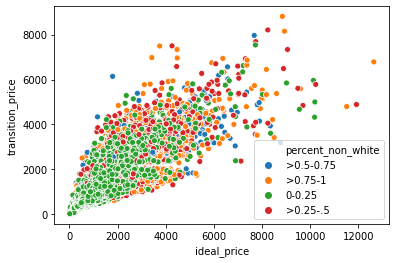

In [185]:
pnw_plot = sns.scatterplot(data=md, x="ideal_price", y="transition_price", hue = "percent_non_white")
pnw_plot = pnw_plot.get_figure()
pnw_plot.savefig("eda_plots/pnw.png")

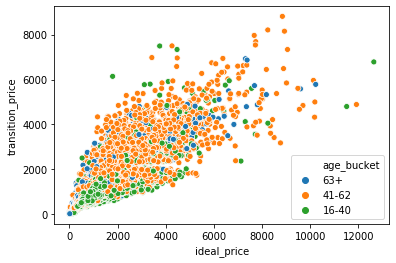

In [186]:
age_plot = sns.scatterplot(data=md, x="ideal_price", y="transition_price", hue = "age_bucket")
age_plot = age_plot.get_figure()
age_plot.savefig("eda_plots/age.png")

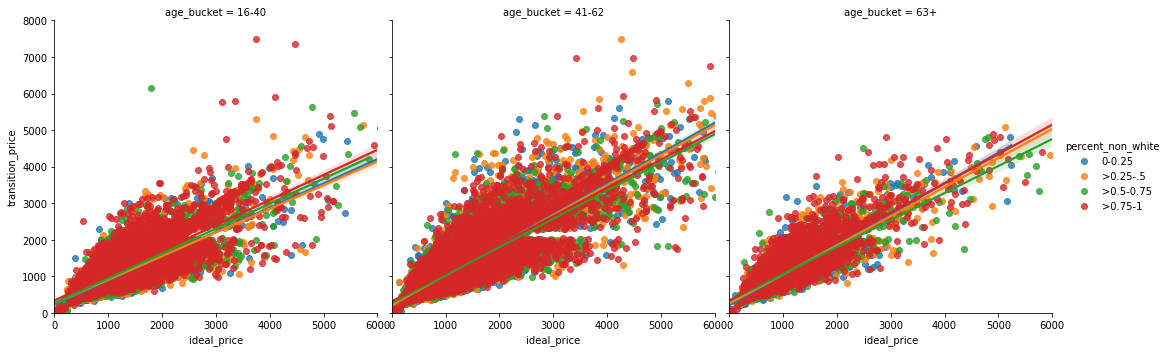

In [189]:
intersectional_plot = sns.lmplot( x="ideal_price", y="transition_price", hue = 'percent_non_white', col = "age_bucket", data=md)
intersectional_plot = intersectional_plot.set(xlim = (0, 6000))
intersectional_plot = intersectional_plot.set(ylim = (0, 8000)) 
#intersectional_plot = intersectional_plot.get_figure()
intersectional_plot.savefig("eda_plots/intersectional.png")

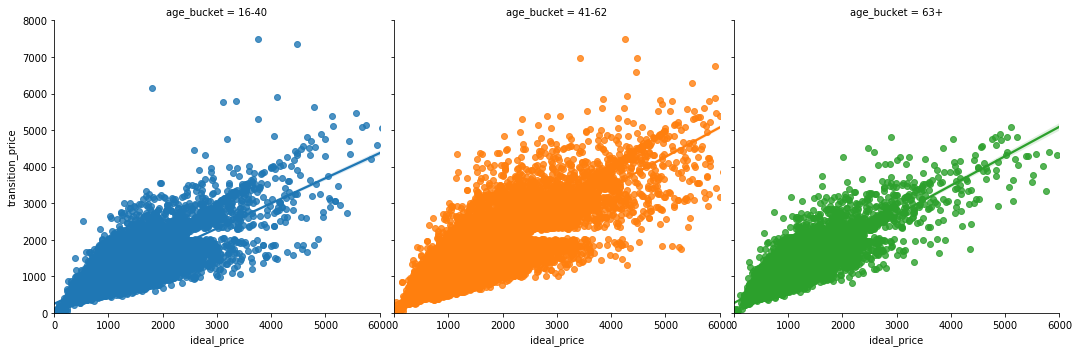

In [179]:
a_plot = sns.lmplot( x="ideal_price", y="transition_price", hue = 'age_bucket', col = "age_bucket", data=md)
a_plot.set(xlim = (0, 6000))
a_plot.set(ylim = (0, 8000)) 
plt.show()

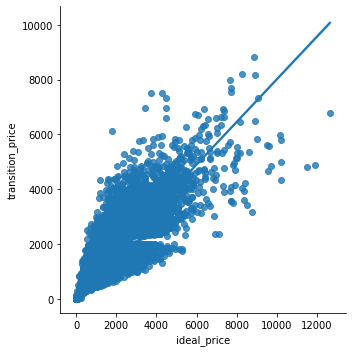

In [198]:
a_plot = sns.lmplot( x="ideal_price", y="transition_price", data=md, aspect = 1)
#a_plot.set(xlim = (0, 6000))
#a_plot.set(ylim = (0, 8000)) 
a_plot.savefig("eda_plots/aggregate_line.png")

In [110]:
maryland_customers.loc[maryland_customers['IncCat']  == 'Small Increase',] 

territory gender  birthdate  ypc  current_price  ideal_price  \
6            601      M  2/26/1963    0        1266.17      1559.70   
9            601      F   7/4/1966    0         655.97       697.31   
12           601      F  10/9/1975    0         756.60      1619.37   
14           601      F  8/28/1978    0         688.33       796.21   
15           601      M  5/14/1979    0        1658.50      2541.83   
...          ...    ...        ...  ...            ...          ...   
92784       1921      F  1/22/1988    5         560.69       947.92   
92785       1921      M   2/3/1988    5         804.27      1092.89   
92787       1921      M   7/2/1988    5         572.43       770.65   
92789       1921      F  5/17/1989    5         847.40      1192.51   
92790       1921      M  7/16/1990    5        1184.31      1459.55   

       transition_price  underlying_premium  fixed_expenses  \
6               1325.15             1050.25          147.58   
9                688.63              497.17          147.58   
12               792.87              612.48          168.08   
14               722.04              509.80          147.58   
15              1736.42             1464.95          204.38   
...                 ...                 ...             ...   
92784            588.72              403.23          152.08   
92785            843.84              619.83          175.98   
92787            599.10              419.05          147.58   
92789            887.40              588.48          147.58   
92790           1242.27              872.84          187.78   

       underlying_total_premium  ...  shift_category_new is_above_current  \
6                       1197.83  ...      Small Increase            False   
9                        644.75  ...      Small Increase            False   
12                       780.56  ...      Small Increase            False   
14                       657.38  ...      Small Increase            False   
15                      1669.33  ...      Small Increase            False   
...                         ...  ...                 ...              ...   
92784                    555.31  ...      Small Increase            False   
92785                    795.81  ...      Small Increase            False   
92787                    566.63  ...      Small Increase            False   
92789                    736.06  ...      Small Increase            False   
92790                   1060.62  ...      Small Increase            False   

      is_above_difference is_both  IndMinCur  SelMinCur SelDivCur  IncDivCur  \
6                   False   False     293.53      58.98  1.046581   1.231825   
9                   False   False      41.34      32.66  1.049789   1.063021   
12                   True   False     862.77      36.27  1.047938   2.140325   
14                  False   False     107.88      33.71  1.048974   1.156727   
15                   True   False     883.33      77.92  1.046982   1.532608   
...                   ...     ...        ...        ...       ...        ...   
92784                True   False     387.23      28.03  1.049992   1.690631   
92785               False   False     288.62      39.57  1.049200   1.358860   
92787               False   False     198.22      26.67  1.046591   1.346278   
92789               False   False     345.11      40.00  1.047203   1.407257   
92790               False   False     275.24      57.96  1.048940   1.232405   

       SelDivInd          IncCat  
6       0.849619  Small Increase  
9       0.987552  Small Increase  
12      0.489616  Small Increase  
14      0.906846  Small Increase  
15      0.683138  Small Increase  
...          ...             ...  
92784   0.621065  Small Increase  
92785   0.772118  Small Increase  
92787   0.777396  Small Increase  
92789   0.744145  Small Increase  
92790   0.851132  Small Increase  

[42221 rows x 40 columns]

In [60]:
maryland_customers.columns

Index(['territory', 'gender', 'birthdate', 'ypc', 'current_price',
       'ideal_price', 'transition_price', 'underlying_premium',
       'fixed_expenses', 'underlying_total_premium', 'cgr_factor', 'cgr', 'aa',
       'county', 'county_code', 'zipcode', 'town', 'area', 'GEO.id2_x',
       'population', 'percentage_nonwhite', 'majority_minority', 'GEO.id2_y',
       'median_income', 'price_change', 'ideal_price_change', 'dob', 'age'],
      dtype='object')

In [120]:
md.columns

Index(['territory', 'gender', 'birthdate', 'ypc', 'current_price',
       'ideal_price', 'transition_price', 'underlying_premium',
       'fixed_expenses', 'underlying_total_premium', 'cgr_factor', 'cgr', 'aa',
       'county', 'county_code', 'zipcode', 'town', 'area', 'GEO.id2_x',
       'population', 'percentage_nonwhite', 'majority_minority', 'GEO.id2_y',
       'median_income', 'price_change', 'ideal_price_change', 'dob', 'age',
       'age_bucket', 'shift_category', 'shift_category_new',
       'is_above_current', 'is_above_difference', 'is_both', 'IndMinCur',
       'SelMinCur', 'SelDivCur', 'IncDivCur', 'SelDivInd', 'IncCat',
       'PNW_bucket4'],
      dtype='object')

In [113]:
maryland_customers.head()

territory gender  birthdate  ypc  current_price  ideal_price  \
0        601      M  10/5/1947    0         863.97       830.58   
1        601      F   7/6/1953    0         828.63       611.14   
2        601      M  4/18/1956    0        1000.59       593.99   
3        601      F  8/16/1956    0         700.42       547.95   
4        601      F  1/23/1957    0         505.92       448.33   

   transition_price  underlying_premium  fixed_expenses  \
0            862.57              673.06          175.98   
1            826.43              612.75          175.98   
2            996.60              858.20          175.98   
3            697.84              571.49          180.48   
4            504.56              333.71          152.08   

   underlying_total_premium  ...  is_above_current is_above_difference  \
0                    849.04  ...             False               False   
1                    788.73  ...             False               False   
2                   1034.18  ...             False               False   
3                    751.97  ...             False               False   
4                    485.79  ...             False               False   

  is_both IndMinCur  SelMinCur  SelDivCur IncDivCur  SelDivInd  \
0   False    -33.39      -1.40   0.998380  0.961353   1.038515   
1   False   -217.49      -2.20   0.997345  0.737531   1.352276   
2   False   -406.60      -3.99   0.996012  0.593640   1.677806   
3   False   -152.47      -2.58   0.996316  0.782316   1.273547   
4   False    -57.59      -1.36   0.997312  0.886168   1.125421   

           IncCat  PNW_bucket4  
0  Large Increase    >0.5-0.75  
1  Large Increase    >0.5-0.75  
2  Large Increase    >0.5-0.75  
3  Large Increase    >0.5-0.75  
4  Large Increase    >0.5-0.75  

[5 rows x 41 columns]

In [79]:
maryland_customers['per']

territory gender   birthdate  ypc  current_price  ideal_price  \
32           601      F    4/9/1966    1        2691.97      3421.82   
55           601      F    3/4/1988    1        2897.88      5222.37   
74           601      M   5/15/1973    2        2484.38      3032.73   
94           601      M   8/12/1969    3        2169.30      3573.24   
158          601      F   3/16/1949    5        2133.72      2585.07   
...          ...    ...         ...  ...            ...          ...   
92327       1915      M  11/28/1961    5        1985.33      3502.02   
92651       1921      M  11/23/1959    5        2236.95      2755.42   
92660       1921      M   12/6/1960    5        4469.10      6694.87   
92672       1921      F   5/14/1962    5        1946.25      3028.58   
92676       1921      M   7/29/1962    5        1946.39      2909.35   

       transition_price  underlying_premium  fixed_expenses  \
32              3223.92             2789.95          157.37   
55              3463.70             2952.85          152.87   
74              2978.50             2141.75          204.38   
94              2594.30             1959.66           81.17   
158             2558.76             1793.16          224.57   
...                 ...                 ...             ...   
92327           2382.31             1685.51           99.17   
92651           2673.62             1576.51          384.08   
92660           5362.37             3907.66          147.58   
92672           2335.24             1561.81          166.37   
92676           2333.08             1519.92          147.58   

       underlying_total_premium  ...  percentage_nonwhite majority_minority  \
32                      2947.32  ...             0.587587              True   
55                      3105.72  ...             0.587587              True   
74                      2346.13  ...             0.587587              True   
94                      2040.83  ...             0.587587              True   
158                     2017.73  ...             0.587587              True   
...                         ...  ...                  ...               ...   
92327                   1784.68  ...             0.151014             False   
92651                   1960.59  ...             0.163431             False   
92660                   4055.24  ...             0.163431             False   
92672                   1728.18  ...             0.163431             False   
92676                   1667.50  ...             0.163431             False   

      GEO.id2_y median_income  price_change  ideal_price_change        dob  \
32      20601.0       94277.0     19.760621           27.112115 1966-04-09   
55      20601.0       94277.0     19.525308           80.213466 1988-03-04   
74      20601.0       94277.0     19.889067           22.071905 1973-05-15   
94      20601.0       94277.0     19.591573           64.718573 1969-08-12   
158     20601.0       94277.0     19.920139           21.153197 1949-03-16   
...         ...           ...           ...                 ...        ...   
92327   21915.0       63438.0     19.995668           76.394856 1961-11-28   
92651   21921.0       62011.0     19.520776           23.177541 1959-11-23   
92660   21921.0       62011.0     19.987693           49.803540 1960-12-06   
92672   21921.0       62011.0     19.986641           55.611047 1962-05-14   
92676   21921.0       62011.0     19.867036           49.474155 1962-07-29   

        age  age_bucket  shift_category  
32     48.0       41-62  Large Increase  
55     26.0       16-40  Large Increase  
74     40.0       16-40  Large Increase  
94     44.0       41-62  Large Increase  
158    65.0         63+  Large Increase  
...     ...         ...             ...  
92327  52.0       41-62  Large Increase  
92651  54.0       41-62  Large Increase  
92660  53.0       41-62  Large Increase  
92672  51.0       41-62  Large Increase  
92676  51.0       41-62  Large Increa

In [80]:
effective_date

Timestamp('2014-04-11 00:00:00')